In [1]:
from pdf2image import convert_from_path


In [2]:
pages = convert_from_path('/home/vimalkumar.s/Documents/pdf_pages/final_images/input_file/input-1-20.pdf', 500)


In [38]:
x = []
for page in pages:
    x.append(page)

In [39]:
c = []
for i in x:
    print(i)

<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=4160x5420 at 0x7F5EF9261250>
<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=4152x5412 at 0x7F5EF9261610>
<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=4182x5438 at 0x7F5EF92471F0>
<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=4142x5409 at 0x7F5EF9254520>
<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=4182x5444 at 0x7F5EF9254640>
<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=4121x5393 at 0x7F5EF92546A0>
<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=4172x5436 at 0x7F5EF9254790>
<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=4130x5402 at 0x7F5EF9254760>
<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=4109x5387 at 0x7F5EF92547C0>
<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=4111x5385 at 0x7F5EF92547F0>
<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=4098x5378 at 0x7F5EF9254850>
<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=4089x5369 at 0x7F5EF9254880>
<PIL.PpmImagePlu

In [52]:
for i in range(0,len(x)):
    x[i].save('/home/vimalkumar.s/Documents/pdf_pages/final_images/page_'+str(i+1)+'.jpeg')

In [48]:
x[17].save('/home/vimalkumar.s/Documents/pdf_pages/final_images/18/page_18_1.jpeg')

In [23]:
count = 1
exe = 'page_'+str(count)+'.jpeg'
print(exe)

page_1.jpeg


In [5]:
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    from PIL import Image
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
    import cv2
    import os
    import math
    import sys
    import numpy as np
    import pytesseract
    import io 
    import csv
    import pandas as pd
    import shutil, os
    import warnings
    warnings.filterwarnings('ignore')
    def extract_cell_images_from_table(image):
        BLUR_KERNEL_SIZE = (17, 17)
        STD_DEV_X_DIRECTION = 0
        STD_DEV_Y_DIRECTION = 0
        blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
        MAX_COLOR_VAL = 255
        BLOCK_SIZE = 15
        SUBTRACT_FROM_MEAN = -2

        img_bin = cv2.adaptiveThreshold(
            ~blurred,
            MAX_COLOR_VAL,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,
            BLOCK_SIZE,
            SUBTRACT_FROM_MEAN,
        )
        vertical = horizontal = img_bin.copy()
        SCALE = 5
        image_width, image_height = horizontal.shape
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
        horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
        vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)

        horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
        vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))

        mask = horizontally_dilated + vertically_dilated
        print(type(mask))
        #plt.imshow(mask)
        ff = Image.fromarray(mask)
        ff.save('/home/vimalkumar.s/Documents/pdf_pages/test/masking.jpeg')
        img = cv2.imread('/home/vimalkumar.s/Documents/pdf_pages/test/masking.jpeg')
        
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray,200,100)
        lines = cv2.HoughLinesP(edges,2,np.pi/180,500,maxLineGap = 20000)

        for line in lines:
            x1,y1,x2,y2 = line[0]
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),15)
            cv2.imwrite('/home/vimalkumar.s/Documents/pdf_pages/test/final_image.jpeg',img)
        #plt.imshow(mask)    
        cnt = cv2.imread('/home/vimalkumar.s/Documents/pdf_pages/test/final_image.jpeg',0)   
        contours, heirarchy = cv2.findContours(
            cnt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
        )

        perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
        epsilons = [0.05 * p for p in perimeter_lengths]
        approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]

        # Filter out contours that aren't rectangular. Those that aren't rectangular
        # are probably noise.
        approx_rects = [p for p in approx_polys if len(p) == 4]
        bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

        # Filter out rectangles that are too narrow or too short.
        MIN_RECT_WIDTH = 40
        MIN_RECT_HEIGHT = 10
        bounding_rects = [
            r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
        ]

        # The largest bounding rectangle is assumed to be the entire table.
        # Remove it from the list. We don't want to accidentally try to OCR
        # the entire table.
        largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
        bounding_rects = [b for b in bounding_rects if b is not largest_rect]

        cells = [c for c in bounding_rects]
        def cell_in_same_row(c1, c2):
            c1_center = c1[1] + c1[3] - c1[3] / 2
            c2_bottom = c2[1] + c2[3]
            c2_top = c2[1]
            return c2_top < c1_center < c2_bottom

        orig_cells = [c for c in cells]
        rows = []
        while cells:
            first = cells[0]
            rest = cells[1:]
            cells_in_same_row = sorted(
                [
                    c for c in rest
                    if cell_in_same_row(c, first)
                ],
                key=lambda c: c[0]
            )

            row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
            rows.append(row_cells)
            cells = [
                c for c in rest
                if not cell_in_same_row(c, first)
            ]

        # Sort rows by average height of their center.
        def avg_height_of_center(row):
            centers = [y + h - h / 2 for x, y, w, h in row]
            return sum(centers) / len(centers)

        rows.sort(key=avg_height_of_center)
        cell_images_rows = []
        for row in rows:
            cell_images_row = []
            for x, y, w, h in row:
                cell_images_row.append(image[y:y+h, x:x+w])
            cell_images_rows.append(cell_images_row)
        return cell_images_rows

    def main(f):
        results = []
        directory, filename = os.path.split(f)
        table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        rows = extract_cell_images_from_table(table)
        #cell_img_dir = os.path.join(directory, "cells")
        #os.makedirs(cell_img_dir, exist_ok=True)
        out_path = os.path.join('/home/vimalkumar.s/Documents/pdf_pages/testing/30/ttt')
        paths = []
        for i, row in enumerate(rows):
            for j, cell in enumerate(row):
                cell_filename = "{:03d}-{:03d}.jpeg".format(i, j)
                #print(cell_filename)
                path = os.path.join(out_path, cell_filename)
                #print(path)
                cv2.imwrite(path, cell)
                
                paths.append(path)
        return paths
    f = '/home/vimalkumar.s/Documents/pdf_pages/testing/30/page_30.jpeg'
    main(f)

<class 'numpy.ndarray'>
/home/vimalkumar.s/Documents/pdf_pages/testing/30/ttt/000-000.jpeg
/home/vimalkumar.s/Documents/pdf_pages/testing/30/ttt/000-001.jpeg
/home/vimalkumar.s/Documents/pdf_pages/testing/30/ttt/000-002.jpeg
/home/vimalkumar.s/Documents/pdf_pages/testing/30/ttt/001-000.jpeg
/home/vimalkumar.s/Documents/pdf_pages/testing/30/ttt/001-001.jpeg
/home/vimalkumar.s/Documents/pdf_pages/testing/30/ttt/001-002.jpeg
/home/vimalkumar.s/Documents/pdf_pages/testing/30/ttt/002-000.jpeg
/home/vimalkumar.s/Documents/pdf_pages/testing/30/ttt/002-001.jpeg
/home/vimalkumar.s/Documents/pdf_pages/testing/30/ttt/002-002.jpeg
/home/vimalkumar.s/Documents/pdf_pages/testing/30/ttt/003-000.jpeg
/home/vimalkumar.s/Documents/pdf_pages/testing/30/ttt/003-001.jpeg
/home/vimalkumar.s/Documents/pdf_pages/testing/30/ttt/003-002.jpeg
/home/vimalkumar.s/Documents/pdf_pages/testing/30/ttt/004-000.jpeg
/home/vimalkumar.s/Documents/pdf_pages/testing/30/ttt/004-001.jpeg
/home/vimalkumar.s/Documents/pdf_pages

In [13]:
img_1 = pytesseract.image_to_string('/home/vimalkumar.s/Documents/pdf_pages/input_pdf/test/1/cells/001-001.tif')
print(img_1)

51,000 24-Aug-92 D 54 00345

967 S LOCUST ST DENV 562,500
tTyRES znA-1 SubSUN VALLEY Br2 Bal Sq 836
Ln45,000 Lot50X125 E MbOXO 8 U:
TyCV 10.12 & Bst §S Acr PrOxXO M:2 F 836
PIT! $470 F Fint Fp LrOXO  =oL:
T 511 FlinN Gar HtG,FA prOXO~ 2B:
MIP N ¥r1955 SwrPUB werPUB xrOXO cstSUsty A
Trm CV,F,V S 2.80 B 2.80 ER

k

AT,CP,DS,ES,FE,GA,ST,UT,WC

LatANDREW RIZZUTO 9 ph795-5832 s6630 -6850 -6
of fRE/MAX ACTION Ph773-6299 2p80224 | 653313



In [15]:
img_1 = pytesseract.image_to_string('/home/vimalkumar.s/Documents/pdf_pages/input_pdf/test/1/cells/001-001.tif')
print(img_1)

51,000 24-Aug-92 D 54 F 00345

967 S LOCUST ST DENV 552,500
TyRES 2znA-1 SubSUN VALLEY Br2 Bal Sq 836
Ln45,000 LotS0X125 E MbOXO 8 UU:
TyCV 10.12 & Best S aAcr PrOxO M:2 F 836
PITl $470 F Fint Pp LrOxXO iL:
Tx 511 FlinN Gar HtG.FA prOXO_ B:
MIP N ¥r1955 SwrPUB wrerPUB xkrOXO cetSU sty A
Trm CV,F,V S 2.60 B 2.80 ER

k

AT,CP,DS,ES,FE,GA,ST,UT,WC

LstANDREW RIZZUTO = pPh795-5832 s6630 -6850 -6
of tRE/MAX ACTION Ph773-6299 2p80224 |653313



<class 'numpy.ndarray'>


['/home/vimalkumar.s/Documents/pdf_pages/final_images/1/cells/000-000.tif',
 '/home/vimalkumar.s/Documents/pdf_pages/final_images/1/cells/000-001.tif',
 '/home/vimalkumar.s/Documents/pdf_pages/final_images/1/cells/000-002.tif',
 '/home/vimalkumar.s/Documents/pdf_pages/final_images/1/cells/001-000.tif',
 '/home/vimalkumar.s/Documents/pdf_pages/final_images/1/cells/001-001.tif',
 '/home/vimalkumar.s/Documents/pdf_pages/final_images/1/cells/001-002.tif',
 '/home/vimalkumar.s/Documents/pdf_pages/final_images/1/cells/002-000.tif',
 '/home/vimalkumar.s/Documents/pdf_pages/final_images/1/cells/002-001.tif',
 '/home/vimalkumar.s/Documents/pdf_pages/final_images/1/cells/002-002.tif',
 '/home/vimalkumar.s/Documents/pdf_pages/final_images/1/cells/003-000.tif',
 '/home/vimalkumar.s/Documents/pdf_pages/final_images/1/cells/003-001.tif',
 '/home/vimalkumar.s/Documents/pdf_pages/final_images/1/cells/003-002.tif',
 '/home/vimalkumar.s/Documents/pdf_pages/final_images/1/cells/004-000.tif',
 '/home/vima

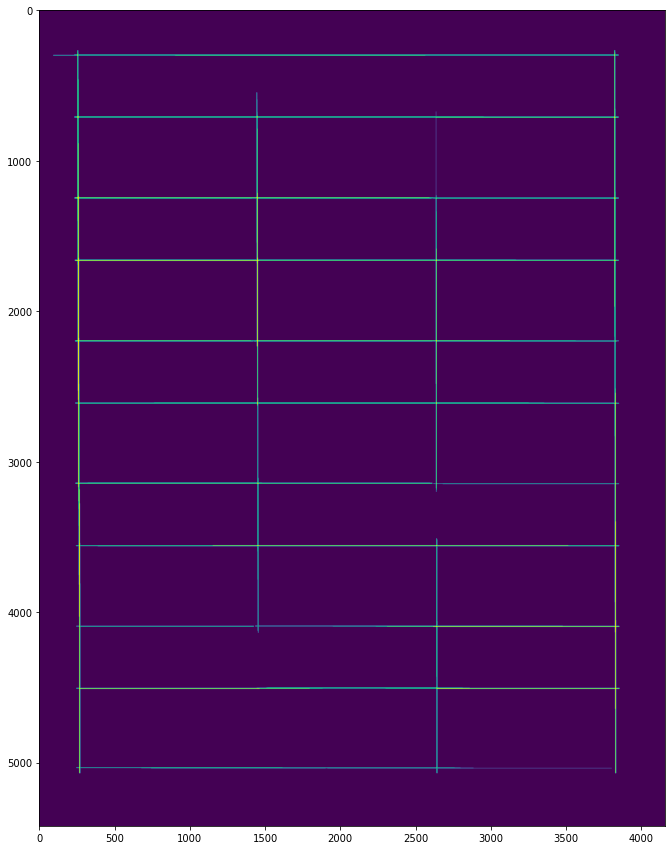

In [75]:
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    from PIL import Image
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
    import cv2
    import os
    import math
    import sys
    import numpy as np
    import pytesseract
    import io 
    import csv
    import pandas as pd
    import shutil, os
    import warnings
    warnings.filterwarnings('ignore')
    def extract_cell_images_from_table(image):
        BLUR_KERNEL_SIZE = (17, 17)
        STD_DEV_X_DIRECTION = 0
        STD_DEV_Y_DIRECTION = 0
        blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
        MAX_COLOR_VAL = 255
        BLOCK_SIZE = 15
        SUBTRACT_FROM_MEAN = -2

        img_bin = cv2.adaptiveThreshold(
            ~blurred,
            MAX_COLOR_VAL,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,
            BLOCK_SIZE,
            SUBTRACT_FROM_MEAN,
        )
        vertical = horizontal = img_bin.copy()
        SCALE = 5
        image_width, image_height = horizontal.shape
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
        horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
        vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)

        horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
        vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))

        mask = horizontally_dilated + vertically_dilated
        print(type(mask))
        plt.figure(figsize=(15,15))
        plt.imshow(mask)
        ff = Image.fromarray(mask)
        ff.save('/home/vimalkumar.s/Documents/pdf_pages/test/masking.jpeg')
        img = cv2.imread('/home/vimalkumar.s/Documents/pdf_pages/test/masking.jpeg')
        
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray,200,100)
        lines = cv2.HoughLinesP(edges,2,np.pi/180,500,maxLineGap = 20000)

        for line in lines:
            x1,y1,x2,y2 = line[0]
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),15)
            cv2.imwrite('/home/vimalkumar.s/Documents/pdf_pages/test/final_image.jpeg',img)
        #plt.imshow(mask)    
        cnt = cv2.imread('/home/vimalkumar.s/Documents/pdf_pages/test/final_image.jpeg',0)   
        contours, heirarchy = cv2.findContours(
            cnt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
        )

        perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
        epsilons = [0.05 * p for p in perimeter_lengths]
        approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]

        # Filter out contours that aren't rectangular. Those that aren't rectangular
        # are probably noise.
        approx_rects = [p for p in approx_polys if len(p) == 4]
        bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

        # Filter out rectangles that are too narrow or too short.
        MIN_RECT_WIDTH = 40
        MIN_RECT_HEIGHT = 10
        bounding_rects = [
            r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
        ]

        # The largest bounding rectangle is assumed to be the entire table.
        # Remove it from the list. We don't want to accidentally try to OCR
        # the entire table.
        largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
        bounding_rects = [b for b in bounding_rects if b is not largest_rect]

        cells = [c for c in bounding_rects]
        def cell_in_same_row(c1, c2):
            c1_center = c1[1] + c1[3] - c1[3] / 2
            c2_bottom = c2[1] + c2[3]
            c2_top = c2[1]
            return c2_top < c1_center < c2_bottom

        orig_cells = [c for c in cells]
        rows = []
        while cells:
            first = cells[0]
            rest = cells[1:]
            cells_in_same_row = sorted(
                [
                    c for c in rest
                    if cell_in_same_row(c, first)
                ],
                key=lambda c: c[0]
            )

            row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
            rows.append(row_cells)
            cells = [
                c for c in rest
                if not cell_in_same_row(c, first)
            ]

        # Sort rows by average height of their center.
        def avg_height_of_center(row):
            centers = [y + h - h / 2 for x, y, w, h in row]
            return sum(centers) / len(centers)

        rows.sort(key=avg_height_of_center)
        cell_images_rows = []
        for row in rows:
            cell_images_row = []
            for x, y, w, h in row:
                cell_images_row.append(image[y:y+h, x:x+w])
            cell_images_rows.append(cell_images_row)
        return cell_images_rows

    def main(f):
        results = []
        directory, filename = os.path.split(f)
        table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        rows = extract_cell_images_from_table(table)
        #cell_img_dir = os.path.join(directory, "cells")
        #os.makedirs(cell_img_dir, exist_ok=True)
        out_path = os.path.join('/home/vimalkumar.s/Documents/pdf_pages/final_images/1/cells')
        paths = []
        for i, row in enumerate(rows):
            for j, cell in enumerate(row):
                cell_filename = "{:03d}-{:03d}.tif".format(i, j)
                #print(cell_filename)
                path = os.path.join(out_path, cell_filename)
                #print(path)
                cv2.imwrite(path, cell)
                
                paths.append(path)
                quality_file = cv2.imread(os.path.join(out_path,cell_filename))
                b,g,r = cv2.split(quality_file)           # get b,g,r
                rgb_img = cv2.merge([r,g,b])     # switch it to rgb

                # Denoising

                dst = cv2.fastNlMeansDenoisingColored(quality_file,None,10,10,7,21) 
                b,g,r = cv2.split(dst)           # get b,g,r
                rgb_dst = cv2.merge([r,g,b])     # switch it to rgb
                #type(rgb_dst)
                x = Image.fromarray(rgb_dst)
                x.save(os.path.join(out_path,cell_filename),quality = 100)
        return paths
    f = '/home/vimalkumar.s/Documents/pdf_pages/final_images/1/page_1.jpeg'
    main(f)

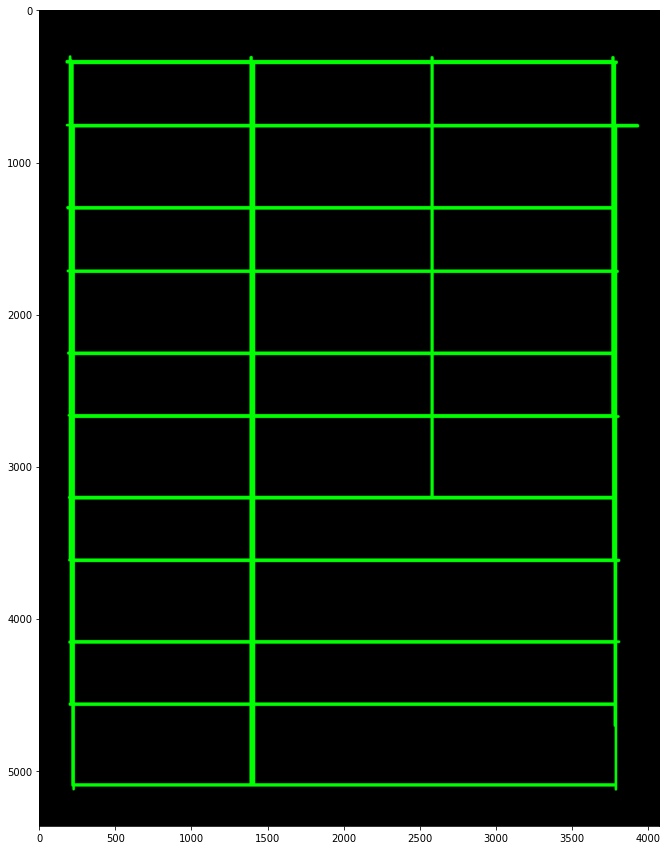

In [55]:
        img = cv2.imread('/home/vimalkumar.s/Documents/pdf_pages/test/masking.jpeg')
        
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray,200,100)
        lines = cv2.HoughLinesP(edges,2,np.pi/180,500,maxLineGap = 20000)

        for line in lines:
            x1,y1,x2,y2 = line[0]
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),15)
        plt.figure(figsize=(15,15))
        plt.imshow(img)